In [1]:
import torch
from torch import nn
from PIL import Image
from torch import optim
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF    
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
#pré processamento
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(45),
                                       transforms.RandomAffine(45),
                                       transforms.ColorJitter(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

# 10-crop para o teste
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.TenCrop(224),
                                      transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                      transforms.Lambda(lambda crops: torch.stack([transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(crop) for crop in crops]))])

train_data = datasets.ImageFolder("./food-101/train", transform=train_transforms)
test_data = datasets.ImageFolder("./food-101/test", transform=test_transforms)

# Using the image datasets and the tranforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size= 64, shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

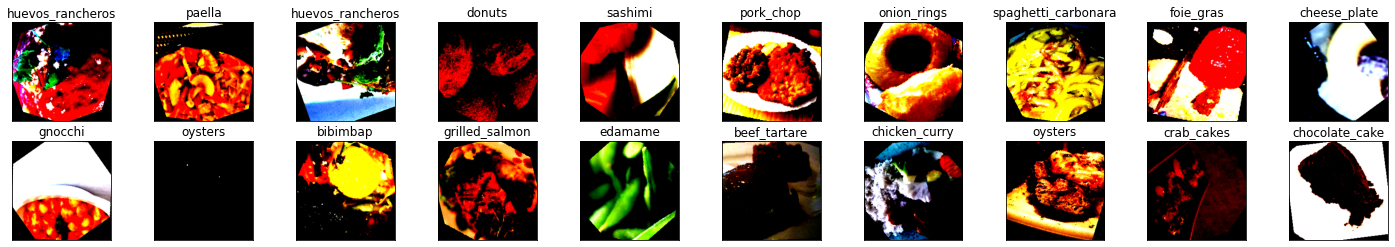

In [3]:
# obtain one batch of training images
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

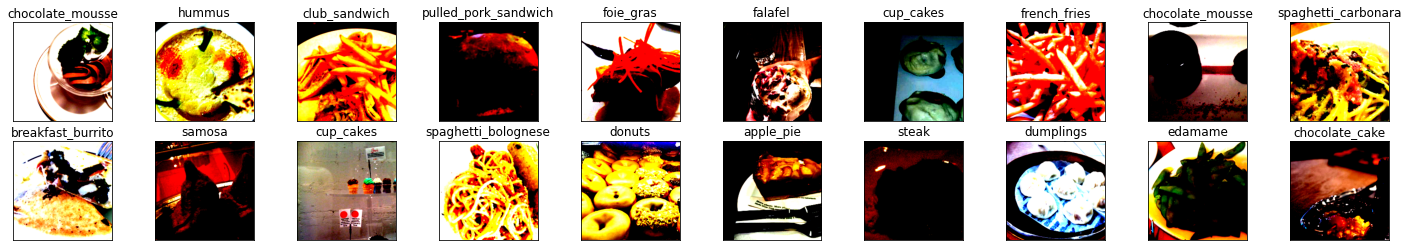

In [6]:
# obtain one batch of testing images
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx][0], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [4]:
# print out some data stats
print('Number of training images: ', len(train_data))
print('Number of testing images: ', len(test_data))

with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
print('Number of classes: ', len(classes))    

# Analyzing the shape of one batch
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

print('Shape of first batch of training images: ', train_images.shape)
print('Shape of first batch of test images: ', test_images.shape) # 5-D array because of 10 crops

Number of training images:  75750
Number of testing images:  25250
Number of classes:  101
Shape of first batch of training images:  torch.Size([64, 3, 224, 224])
Shape of first batch of test images:  torch.Size([64, 10, 3, 224, 224])


In [ ]:
model = models.resnet50(pretrained=True)
# Congelando as camadas pré-aprendidas do resnet para treinar apenas a última camada
# que será adicionada abaixo
for param in model.parameters():
  param.requies_grad = False
  
# Trocando a camada classificadora para ter 101 saídas,
# para reconhecer as nossas 101 classes de comida
classifier = nn.Linear(2048, 101)
model.fc = classifier
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent with momentum)
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

# secify learning rate scheduler (if there is no further decrease in loss for next 5 epochs 
# then lower the learning rate by 0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)

In [ ]:
from tqdm import tqdm

model.to(device)
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    train_accuracy = 0.0
    valid_loss = 0.0
    val_accuracy = 0.0
    
    model.train()
    for data, target in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # Calculate training accuracy
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
    
    torch.save(model.state_dict(), rf'./trained_model_epoch{epoch+1}.pth')
    
    checkpoint = {"model": model,
                      "criterion": criterion,
                      "epochs": epoch,
                      "optimizer_state": optimizer.state_dict(),
                      "model_state": model.state_dict(),
                      "valid_loss_min": valid_loss}
    
    # save model in colab
    torch.save(checkpoint, rf'./res50_model_checkpoint_epoch{epoch}.pth')
        
    # ######################    
    # # validate the model #
    # ######################
    # model.eval()
    # with torch.no_grad():
    #     for data, target in test_loader:
    #         # move tensors to GPU if CUDA is available
    #         if train_on_gpu:
    #             data, target = data.cuda(), target.cuda()
            
    #         bs, ncrops, c, h, w = data.size()
    #         # forward pass: compute predicted outputs by passing inputs to the model
    #         temp_output = model(data.view(-1, c, h, w))
    #         output = temp_output.view(bs, ncrops, -1).mean(1)
    #         # calculate the batch loss
    #         loss = criterion(output, target)
    #         # update average validation loss 
    #         valid_loss += loss.item()*data.size(0)
    #         # Calculate validation accuracy
    #         top_p, top_class = output.topk(1, dim=1)
    #         equals = top_class == target.view(*top_class.shape)
    #         val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
    
    # calculate average losses and accuracies
    train_loss = train_loss/len(train_loader.dataset)
    train_accuracy = train_accuracy/len(train_loader.dataset)
    # Learning rate scheduler step
    scheduler.step(valid_loss) 
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f}'.format(epoch, train_loss, train_accuracy))
    
    # # save model if validation loss has decreased
    # if valid_loss <= valid_loss_min:
    #     print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        
    #     checkpoint = {"model": model,
    #                   "criterion": criterion,
    #                   "epochs": epoch,
    #                   "optimizer_state": optimizer.state_dict(),
    #                   "model_state": model.state_dict(),
    #                   "valid_loss_min": valid_loss}
    
    #     # save model in colab
    #     torch.save(checkpoint, 'res50_model_checkpoint.pth')
    #     valid_loss_min = valid_loss

100%|██████████| 1184/1184 [10:05<00:00,  1.96it/s]


Epoch: 1 	Training Loss: 3.1826 	Training Accuracy: 0.2724


100%|██████████| 1184/1184 [08:23<00:00,  2.35it/s]


Epoch: 2 	Training Loss: 2.7613 	Training Accuracy: 0.3473


100%|██████████| 1184/1184 [08:29<00:00,  2.33it/s]


Epoch: 3 	Training Loss: 2.6842 	Training Accuracy: 0.3642


100%|██████████| 1184/1184 [08:21<00:00,  2.36it/s]


Epoch: 4 	Training Loss: 2.6460 	Training Accuracy: 0.3710


100%|██████████| 1184/1184 [08:22<00:00,  2.35it/s]


Epoch: 5 	Training Loss: 2.6192 	Training Accuracy: 0.3778


100%|██████████| 1184/1184 [08:22<00:00,  2.35it/s]


Epoch: 6 	Training Loss: 2.5886 	Training Accuracy: 0.3848


100%|██████████| 1184/1184 [07:42<00:00,  2.56it/s]


Epoch: 7 	Training Loss: 2.5678 	Training Accuracy: 0.3877


100%|██████████| 1184/1184 [07:29<00:00,  2.64it/s]


Epoch: 8 	Training Loss: 2.4025 	Training Accuracy: 0.4197


100%|██████████| 1184/1184 [07:29<00:00,  2.64it/s]


Epoch: 9 	Training Loss: 2.3932 	Training Accuracy: 0.4237


100%|██████████| 1184/1184 [07:28<00:00,  2.64it/s]


Epoch: 10 	Training Loss: 2.3856 	Training Accuracy: 0.4252


100%|██████████| 1184/1184 [07:29<00:00,  2.64it/s]


Epoch: 11 	Training Loss: 2.3737 	Training Accuracy: 0.4288


100%|██████████| 1184/1184 [07:29<00:00,  2.63it/s]


Epoch: 12 	Training Loss: 2.3743 	Training Accuracy: 0.4295


100%|██████████| 1184/1184 [07:28<00:00,  2.64it/s]


Epoch: 13 	Training Loss: 2.3673 	Training Accuracy: 0.4317


100%|██████████| 1184/1184 [07:29<00:00,  2.64it/s]


Epoch: 14 	Training Loss: 2.3589 	Training Accuracy: 0.4331


100%|██████████| 1184/1184 [07:29<00:00,  2.63it/s]


Epoch: 15 	Training Loss: 2.3582 	Training Accuracy: 0.4334


100%|██████████| 1184/1184 [07:29<00:00,  2.64it/s]


Epoch: 16 	Training Loss: 2.3498 	Training Accuracy: 0.4328


100%|██████████| 1184/1184 [07:29<00:00,  2.64it/s]


Epoch: 17 	Training Loss: 2.3604 	Training Accuracy: 0.4323


 83%|████████▎ | 982/1184 [06:53<01:25,  2.37it/s]


KeyboardInterrupt: 

In [20]:
#resnet 50 pré treinado no imagenet
model = models.resnet50(pretrained=True)

# Trocando a camada classificadora para ter 101 saídas,
# para reconhecer as nossas 101 classes de comida
classifier = nn.Linear(2048, 101)
model.fc = classifier
#carregando o modelo apos a epoca 8
model_path = './trained_model_epoch8.pth'
model.load_state_dict(torch.load(model_path))
criterion = nn.CrossEntropyLoss()

print(model)

c:\Users\luisg\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\luisg\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
#testando o modelo depois de treinar somente a camada classificadora

from tqdm import tqdm
# Create list of class names
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

#move model to gpu
model.to(device)
model.eval()

# iterate over test data
with torch.no_grad():
  for data, target in tqdm(test_loader):
    # move tensors to GPU if CUDA is available    
    data, target = data.to(device), target.to(device)
          
    ## For 10-crop Testing
    bs, ncrops, c, h, w = data.size()
    # forward pass: compute predicted outputs by passing inputs to the model
    temp_output = model(data.view(-1, c, h, w))
    output = temp_output.view(bs, ncrops, -1).mean(1)
    # calculate the batch loss
    loss = criterion(output, target)
    # update average test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %.2f%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i],
                                                         np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                      np.sum(class_correct), np.sum(class_total)))

100%|██████████| 395/395 [36:24<00:00,  5.53s/it]

Test Loss: 1.954347

Test Accuracy of apple_pie: 18.00% (45/250)
Test Accuracy of baby_back_ribs: 67.60% (169/250)
Test Accuracy of baklava: 40.40% (101/250)
Test Accuracy of beef_carpaccio: 47.20% (118/250)
Test Accuracy of beef_tartare: 33.20% (83/250)
Test Accuracy of beet_salad: 44.40% (111/250)
Test Accuracy of beignets: 71.20% (178/250)
Test Accuracy of bibimbap: 79.20% (198/250)
Test Accuracy of bread_pudding: 2.40% ( 6/250)
Test Accuracy of breakfast_burrito: 18.80% (47/250)
Test Accuracy of bruschetta: 38.00% (95/250)
Test Accuracy of caesar_salad: 28.00% (70/250)
Test Accuracy of cannoli: 58.00% (145/250)
Test Accuracy of caprese_salad: 37.20% (93/250)
Test Accuracy of carrot_cake: 26.80% (67/250)
Test Accuracy of ceviche: 34.00% (85/250)
Test Accuracy of cheesecake: 63.60% (159/250)
Test Accuracy of cheese_plate: 10.00% (25/250)
Test Accuracy of chicken_curry: 35.60% (89/250)
Test Accuracy of chicken_quesadilla: 30.00% (75/250)
Test Accuracy of chicken_wings: 80.00% (200/250

## Training the entire network (Unfreeze Initial Layers + Use Final Layer's previously Trained Weights)

In [30]:
# Load the saved model from last checkpoint
checkpoint = torch.load(r"./res50_model_checkpoint_epoch9.pth", map_location='cpu')

# Use entire network for training
model = models.resnet50(pretrained=False)
# for param in model.parameters():
#   param.requires_grad = False

    
classifier = nn.Linear(2048, 101)
model.fc = classifier

model.load_state_dict(checkpoint['model_state'], strict=False)

# specify loss function (categorical cross-entropy) same as used earlier
criterion = nn.CrossEntropyLoss()

# specify optimizer same as used earlier
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# secify scheduler same as used earlier
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)

# Check the saved model's last epoch and last validation loss
valid_loss = checkpoint["valid_loss_min"] 
num_epoch = checkpoint['epochs']

c:\Users\luisg\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\luisg\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [31]:
# Move the model to GPU if CUDA is available
model.to(device)

# number of epochs to train the model 
n_epochs = 65  # new number of epochs

valid_loss_min = valid_loss # track change in validation loss

for epoch in range(num_epoch+1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    train_accuracy = 0.0
    valid_loss = 0.0
    val_accuracy = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    print("Training on epoch {}".format(epoch))
    for data, target in tqdm(train_loader, desc="training"):
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # Calculate training accuracy
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
        
    checkpoint = {"model": model,
                  "criterion": criterion,
                  "epochs": epoch,
                  "optimizer_state": optimizer.state_dict(),
                  "model_state": model.state_dict(),
                  "valid_loss_min": valid_loss}
        
    model_save_name = rf'./resnet50modelFullTrain_epoch{epoch}.pth'
    path = rf"./modelo_fulltreino/{model_save_name}" 
    torch.save(checkpoint, path)
    
    ######################    
    # validate the model #
    ######################
    # model.eval()
    # print("Validating on epoch {}".format(epoch))
    # with torch.no_grad():
    #     for data, target in tqdm(test_loader, desc="validation"):
    #         # move tensors to GPU if CUDA is available
    #         data, target = data.to(device), target.to(device)
            
    #         ## For 10-crop Testing
    #         bs, ncrops, c, h, w = data.size()
    #         # forward pass: compute predicted outputs by passing inputs to the model
    #         temp_output = model(data.view(-1, c, h, w))
    #         output = temp_output.view(bs, ncrops, -1).mean(1)
    #         # calculate the batch loss
    #         loss = criterion(output, target)
    #         # update average validation loss 
    #         valid_loss += loss.item()*data.size(0)
    #         # Calculate validation accuracy
    #         top_p, top_class = output.topk(1, dim=1)
    #         equals = top_class == target.view(*top_class.shape)
    #         val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    train_accuracy = train_accuracy/len(train_loader.dataset)
    # valid_loss = valid_loss/len(test_loader.dataset)
    # val_accuracy = val_accuracy/len(test_loader.dataset)
    # scheduler.step(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f}'.format(
        epoch, train_loss, train_accuracy))

Training on epoch 10


training:   0%|          | 0/1184 [00:00<?, ?it/s]

training: 100%|██████████| 1184/1184 [09:25<00:00,  2.09it/s]


Epoch: 10 	Training Loss: 2.1322 	Training Accuracy: 0.4805
Training on epoch 11


training: 100%|██████████| 1184/1184 [09:16<00:00,  2.13it/s]


Epoch: 11 	Training Loss: 1.9302 	Training Accuracy: 0.5235
Training on epoch 12


training: 100%|██████████| 1184/1184 [09:21<00:00,  2.11it/s]


Epoch: 12 	Training Loss: 1.8251 	Training Accuracy: 0.5457
Training on epoch 13


training: 100%|██████████| 1184/1184 [09:21<00:00,  2.11it/s]


Epoch: 13 	Training Loss: 1.7460 	Training Accuracy: 0.5632
Training on epoch 14


training: 100%|██████████| 1184/1184 [09:45<00:00,  2.02it/s]


Epoch: 14 	Training Loss: 1.6890 	Training Accuracy: 0.5764
Training on epoch 15


training: 100%|██████████| 1184/1184 [10:30<00:00,  1.88it/s]


Epoch: 15 	Training Loss: 1.6313 	Training Accuracy: 0.5909
Training on epoch 16


training: 100%|██████████| 1184/1184 [08:50<00:00,  2.23it/s]


Epoch: 16 	Training Loss: 1.5988 	Training Accuracy: 0.5977
Training on epoch 17


training: 100%|██████████| 1184/1184 [08:56<00:00,  2.21it/s]


Epoch: 17 	Training Loss: 1.5479 	Training Accuracy: 0.6083
Training on epoch 18


training: 100%|██████████| 1184/1184 [09:43<00:00,  2.03it/s]


Epoch: 18 	Training Loss: 1.5230 	Training Accuracy: 0.6138
Training on epoch 19


training: 100%|██████████| 1184/1184 [08:47<00:00,  2.24it/s]


Epoch: 19 	Training Loss: 1.4909 	Training Accuracy: 0.6221
Training on epoch 20


training: 100%|██████████| 1184/1184 [08:49<00:00,  2.24it/s]


Epoch: 20 	Training Loss: 1.4599 	Training Accuracy: 0.6290
Training on epoch 21


training: 100%|██████████| 1184/1184 [09:23<00:00,  2.10it/s]


Epoch: 21 	Training Loss: 1.4375 	Training Accuracy: 0.6337
Training on epoch 22


training: 100%|██████████| 1184/1184 [09:19<00:00,  2.12it/s]


Epoch: 22 	Training Loss: 1.4103 	Training Accuracy: 0.6402
Training on epoch 23


training: 100%|██████████| 1184/1184 [15:55<00:00,  1.24it/s] 


Epoch: 23 	Training Loss: 1.4014 	Training Accuracy: 0.6429
Training on epoch 24


training: 100%|██████████| 1184/1184 [09:35<00:00,  2.06it/s]


Epoch: 24 	Training Loss: 1.3710 	Training Accuracy: 0.6522
Training on epoch 25


training: 100%|██████████| 1184/1184 [08:47<00:00,  2.24it/s]


Epoch: 25 	Training Loss: 1.3559 	Training Accuracy: 0.6539
Training on epoch 26


training: 100%|██████████| 1184/1184 [08:50<00:00,  2.23it/s]


Epoch: 26 	Training Loss: 1.3291 	Training Accuracy: 0.6598
Training on epoch 27


training: 100%|██████████| 1184/1184 [08:20<00:00,  2.37it/s]


Epoch: 27 	Training Loss: 1.3173 	Training Accuracy: 0.6604
Training on epoch 28


training: 100%|██████████| 1184/1184 [07:32<00:00,  2.62it/s]


Epoch: 28 	Training Loss: 1.3009 	Training Accuracy: 0.6659
Training on epoch 29


training: 100%|██████████| 1184/1184 [17:53<00:00,  1.10it/s]   


Epoch: 29 	Training Loss: 1.2900 	Training Accuracy: 0.6683
Training on epoch 30


training: 100%|██████████| 1184/1184 [14:32<00:00,  1.36it/s]


Epoch: 30 	Training Loss: 1.2722 	Training Accuracy: 0.6724
Training on epoch 31


training: 100%|██████████| 1184/1184 [11:09<00:00,  1.77it/s]


Epoch: 31 	Training Loss: 1.2544 	Training Accuracy: 0.6770
Training on epoch 32


training: 100%|██████████| 1184/1184 [08:47<00:00,  2.24it/s]


Epoch: 32 	Training Loss: 1.2505 	Training Accuracy: 0.6774
Training on epoch 33


training: 100%|██████████| 1184/1184 [08:49<00:00,  2.23it/s]


Epoch: 33 	Training Loss: 1.2311 	Training Accuracy: 0.6821
Training on epoch 34


training: 100%|██████████| 1184/1184 [12:48<00:00,  1.54it/s]


Epoch: 34 	Training Loss: 1.2186 	Training Accuracy: 0.6861
Training on epoch 35


training: 100%|██████████| 1184/1184 [12:50<00:00,  1.54it/s]


Epoch: 35 	Training Loss: 1.2021 	Training Accuracy: 0.6896
Training on epoch 36


training:  84%|████████▍ | 999/1184 [08:48<01:37,  1.89it/s]


KeyboardInterrupt: 

In [5]:
# Load the saved model from last checkpoint
checkpoint = torch.load(r"./modelo_fulltreino/resnet50modelFullTrain_epoch35.pth", map_location='cpu')

# Use entire network for training
model = models.resnet50(pretrained=False)
# for param in model.parameters():
#   param.requires_grad = False
    
classifier = nn.Linear(2048, 101)
model.fc = classifier

model.load_state_dict(checkpoint['model_state'], strict=False)

# specify loss function (categorical cross-entropy) same as used earlier
criterion = nn.CrossEntropyLoss()
model.to(device)


c:\Users\luisg\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\luisg\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
from tqdm import tqdm
# Create list of class names
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

#move model to gpu
model.cuda()
model.eval()

# iterate over test data
with torch.no_grad():
  for data, target in tqdm(test_loader):
    
    data, target = data.to(device), target.to(device)
          
    ## For 10-crop Testing
    bs, ncrops, c, h, w = data.size()
    # forward pass: compute predicted outputs by passing inputs to the model
    temp_output = model(data.view(-1, c, h, w))
    output = temp_output.view(bs, ncrops, -1).mean(1)
    # calculate the batch loss
    loss = criterion(output, target)
    # update average test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %.2f%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i],
                                                         np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                      np.sum(class_correct), np.sum(class_total)))

  0%|          | 0/395 [00:00<?, ?it/s]

100%|██████████| 395/395 [43:05<00:00,  6.55s/it]  

Test Loss: 0.716445

Test Accuracy of apple_pie: 54.40% (136/250)
Test Accuracy of baby_back_ribs: 76.00% (190/250)
Test Accuracy of baklava: 89.60% (224/250)
Test Accuracy of beef_carpaccio: 81.20% (203/250)
Test Accuracy of beef_tartare: 80.40% (201/250)
Test Accuracy of beet_salad: 70.00% (175/250)
Test Accuracy of beignets: 86.00% (215/250)
Test Accuracy of bibimbap: 88.00% (220/250)
Test Accuracy of bread_pudding: 56.00% (140/250)
Test Accuracy of breakfast_burrito: 74.40% (186/250)
Test Accuracy of bruschetta: 66.80% (167/250)
Test Accuracy of caesar_salad: 78.80% (197/250)
Test Accuracy of cannoli: 88.40% (221/250)
Test Accuracy of caprese_salad: 84.80% (212/250)
Test Accuracy of carrot_cake: 76.80% (192/250)
Test Accuracy of ceviche: 67.20% (168/250)
Test Accuracy of cheesecake: 88.80% (222/250)
Test Accuracy of cheese_plate: 61.20% (153/250)
Test Accuracy of chicken_curry: 71.60% (179/250)
Test Accuracy of chicken_quesadilla: 80.00% (200/250)
Test Accuracy of chicken_wings: 89

In [25]:
acertos = []
with open('results_per_class.txt') as file:
    txt = file.readlines()
    for line in txt:
        start = line.find('(')+1
        end = line.find(')')
        acertos.append(int(line[start:end].split('/')[0]))
classes_e_acertos = list(zip(classes, acertos))
em_ordem = sorted(classes_e_acertos, key=lambda x: x[1])
em_ordem

[('pork_chop', 114),
 ('steak', 127),
 ('risotto', 133),
 ('apple_pie', 136),
 ('bread_pudding', 140),
 ('huevos_rancheros', 145),
 ('foie_gras', 150),
 ('cheese_plate', 153),
 ('chocolate_cake', 156),
 ('ravioli', 159),
 ('lasagna', 162),
 ('bruschetta', 167),
 ('ceviche', 168),
 ('filet_mignon', 168),
 ('tuna_tartare', 170),
 ('omelette', 171),
 ('shrimp_and_grits', 171),
 ('chocolate_mousse', 173),
 ('tacos', 173),
 ('beet_salad', 175),
 ('crab_cakes', 177),
 ('nachos', 178),
 ('scallops', 178),
 ('chicken_curry', 179),
 ('grilled_cheese_sandwich', 182),
 ('tiramisu', 183),
 ('grilled_salmon', 184),
 ('breakfast_burrito', 186),
 ('ice_cream', 186),
 ('gnocchi', 187),
 ('french_toast', 189),
 ('pulled_pork_sandwich', 189),
 ('baby_back_ribs', 190),
 ('falafel', 191),
 ('garlic_bread', 191),
 ('carrot_cake', 192),
 ('fried_rice', 196),
 ('hummus', 196),
 ('caesar_salad', 197),
 ('chicken_quesadilla', 200),
 ('prime_rib', 200),
 ('beef_tartare', 201),
 ('beef_carpaccio', 203),
 ('macar